In [63]:
save_dats_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/paper1/dats/'

In [184]:
from glob import glob
import pandas as pd
import fastwer
import numpy as np
import matplotlib.pyplot as plt
import re

import Levenshtein

from sys import path
path.append('../')

from utils import split_function_with_delimiters_with_checks as spc
from utils import get_fill_in_types, align_texts_fast

search_doc = r"\\(?:[^a-zA-Z]|[a-zA-Z]+[*=']?)" # search for commands in the document itself

In [153]:
def fix_ocr(dfout_historical):
    dfout_err_h = dfout_historical.copy()

    dfmask = []

    cer_orig = []; wer_orig = []
    cer_corr = []; wer_corr = []
    cer_corr_fix = []; wer_corr_fix = []
    cer_fix = []; wer_fix = []
    pdf_fix_out = []; ocr_fix_out = []
    for i in range(len(dfout_historical)):

        ocr = dfout_historical.iloc[i]['input_text']
        pdf = dfout_historical.iloc[i]['target_text']
        ocr_corr = dfout_historical.iloc[i]['predicted_text']
        
        if pd.isnull(ocr) or pd.isnull(pdf) or pd.isnull(ocr_corr):
            continue
            
        # if not, format
        ocr = str(ocr); pdf = str(pdf)
        ocr_corr = str(ocr_corr)

        # also, do with just taking out locations of citations, refs and inlines:
        # ------ 1. inline math --------
        ind = 0
        pdf_fix = ''
        while ind < len(pdf):
            if '$' in pdf[ind:]:
                i1 = pdf[ind:].index('$')
                i2 = pdf[ind+i1+1:].index('$')+i1+1+1
                # find match
                pdf_fix += pdf[ind:ind+i1]
                pdf_fix += '$'
                #import sys; sys.exit()
                ind += i2
            else:
                pdf_fix += pdf[ind:]
                ind += len(pdf[ind:])

        ind = 0
        ocr_corr_fix = ''
        while ind < len(ocr_corr):
            if '$' in ocr_corr[ind:]:
                i1 = ocr_corr[ind:].index('$')
                nope = False
                try:
                    i2 = ocr_corr[ind+i1+1:].index('$')+i1+1+1
                except:
                    print('no matching $ in OCR corrected fix!')
                    nope = True
                if not nope:
                    # find match
                    ocr_corr_fix += ocr_corr[ind:ind+i1]
                    ocr_corr_fix += '$'
                    #import sys; sys.exit()
                    ind += i2
                else:
                    ind += i1+1
            else:
                ocr_corr_fix += ocr_corr[ind:]
                ind += len(ocr_corr[ind:])

        # ------ 2. citations -----
        ind = 0
        pdf_fix2 = ''
        while ind < len(pdf_fix):
            if '\\cite' in pdf_fix[ind:]:
                ind1,ind2,err = spc(pdf_fix[ind:],function='\\cite',
                        dopen='{',dclose='}',
                       error_out=False)
                if ind1 != -1 and ind2 != -2:
                    pdf_fix2 += pdf_fix[ind:ind+ind1]
                    pdf_fix2 += '`'
                    ind += ind2
                else:
                    ind += pdf_fix[ind:].index('\\cite')+len('\\cite')
            else:
                pdf_fix2 += pdf_fix[ind:]
                ind += len(pdf_fix[ind:])

        ind = 0
        ocr_corr_fix2 = ''
        while ind < len(ocr_corr_fix):
            if '\\cite' in ocr_corr_fix[ind:]:
                ind1,ind2,err = spc(ocr_corr_fix[ind:],function='\\cite',
                        dopen='{',dclose='}',
                       error_out=False)
                if not err:
                    ocr_corr_fix2 += ocr_corr_fix[ind:ind+ind1]
                    ocr_corr_fix2 += '`'
                    ind += ind2
                else:
                    ind += ocr_corr_fix[ind:].index('\\cite')+len('\\cite')
            else:
                ocr_corr_fix2 += ocr_corr_fix[ind:]
                ind += len(ocr_corr_fix[ind:])

         # ------ 3. refs -----
        ind = 0
        pdf_fix3 = ''
        while ind < len(pdf_fix2):
            if '\\ref' in pdf_fix2[ind:]:
                ind1,ind2 = spc(pdf_fix2[ind:],function='\\ref',
                        dopen='{',dclose='}',
                       error_out=True)
                pdf_fix3 += pdf_fix2[ind:ind+ind1]
                pdf_fix3 += '*'
                ind += ind2
            else:
                pdf_fix3 += pdf_fix2[ind:]
                ind += len(pdf_fix2[ind:])

        ind = 0
        ocr_corr_fix3 = ''
        while ind < len(ocr_corr_fix2):
            if '\\ref' in ocr_corr_fix2[ind:]:
                ind1,ind2 = spc(ocr_corr_fix2[ind:],function='\\ref',
                        dopen='{',dclose='}',
                       error_out=True)
                ocr_corr_fix3 += ocr_corr_fix2[ind:ind+ind1]
                ocr_corr_fix3 += '*'
                ind += ind2
            else:
                ocr_corr_fix3 += ocr_corr_fix2[ind:]
                ind += len(ocr_corr_fix2[ind:])

        #if i == 5: import sys; sys.exit()

        # orig errors
        cer_orig_here = fastwer.score_sent(ocr,pdf, 
                                      char_level=True)
        wer_orig_here = fastwer.score_sent(ocr,pdf, 
                                      char_level=False)
        # after correction
        cer_corr_here = fastwer.score_sent(ocr_corr,pdf, 
                                      char_level=True)
        wer_corr_here = fastwer.score_sent(ocr_corr,pdf, 
                                      char_level=False)

        # after correction, with replacement
        cer_corr_fix_here = fastwer.score_sent(ocr_corr_fix3,pdf_fix3, 
                                      char_level=True)
        wer_corr_fix_here = fastwer.score_sent(ocr_corr_fix3,pdf_fix3, 
                                      char_level=False)

        # before correction, with replacement
        cer_fix_here = fastwer.score_sent(ocr,pdf_fix3, 
                                      char_level=True)
        wer_fix_here = fastwer.score_sent(ocr,pdf_fix3, 
                                      char_level=False)


        # ignore if we haven't checked for extra non-tracked things
        pdf_check = pdf_fix3.replace('*','').replace('`','').replace('$','')
        s = re.search(search_doc, pdf_check)
        if s: # skip
            dfmask.append(False)
            continue
        else:
            dfmask.append(True)


        pdf_fix_out.append(pdf_fix3)
        ocr_fix_out.append(ocr_corr_fix3)


        cer_orig.append(cer_orig_here)
        wer_orig.append(wer_orig_here)
        cer_corr.append(cer_corr_here)
        wer_corr.append(wer_corr_here)
        cer_corr_fix.append(cer_corr_fix_here)
        wer_corr_fix.append(wer_corr_fix_here)
        cer_fix.append(cer_fix_here)
        wer_fix.append(wer_fix_here)

    # recopy
    dfout_err_h = dfout_historical.copy().loc[dfmask]

    dfout_err_h['CER Orig'] = cer_orig
    dfout_err_h['WER Orig'] = wer_orig
    dfout_err_h['CER Corrected'] = cer_corr
    dfout_err_h['WER Corrected'] = wer_corr
    dfout_err_h['CER Fix Corrected'] = cer_corr_fix
    dfout_err_h['WER Fix Corrected'] = wer_corr_fix
    dfout_err_h['CER Fix'] = cer_fix
    dfout_err_h['WER Fix'] = wer_fix
    dfout_err_h['target_text_fixed'] = pdf_fix_out
    dfout_err_h['predicted_text_fixed'] = ocr_fix_out
    
    return dfout_err_h


## Batch inference byt5 -- only words, arXiv dataset

In [89]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/latex/'

ender = '_small_words' # 100k for training, 5k val

In [90]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words = d.copy()
    else: # others
        df_byt5_words = pd.concat([df_byt5_words,d],ignore_index=True)

In [91]:
df_byt5_words.head()

,aligned sentences source,aligned sentences target,sentences source,sentences target,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,words source aligned,words target aligned,input_text,target_text,predicted_text
0,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,WWWW WWWWWWWWW WWWW WWWWWWW WWWW WWWW WWW WWW...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,Thev suegested that optical {lis [rom the neu...,They suggested that optical flux from the neu...,They suggested that optical flux from the neu...
1,dust. temperatures of 35. 40. 45 and SOWKK are...,"dust@ temperatures of 35, 40, 45 and @@@K@ are...",dust. temperatures of 35. 40. 45 and SOWKK are...,"dust temperatures of 35, 40, 45 and K are abou...",WWWWW WWWWWWWWWWWW WW WWW WWW WW WWW WWWWW WWW...,WWWW@ WWWWWWWWWWWW WW WWW WWW WW WWW @@@W@ WWW...,WWWWW WWWWWWWWWWWW WW WWW WWW WW WWW WWWWW WWW...,WWWW WWWWWWWWWWWW WW WWW WWW WW WWW W WWW WWWW...,dust. temperatures of 35. 40. 45 and KK are ab...,"dust@ temperatures of 35, 40, 45 and K@ are ab...",dust. temperatures of 35. 40. 45 and KK are ab...,"dust temperatures of 35, 40, 45 and K are abou...","dust temperatures of 35, 40, 45 and K are abou..."
2,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,W WWWWWWWWWW WWWWWWW WWW WWW WWWWWW WWWWWWWWW...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,| comparison between the two panels demonstra...,A comparison between the two panels demonstra...,A comparison between the two panels demonstra...
3,Then. equation ^^^^^^^^^^^(7)^) aud equation ...,"Then, equation \ref{con_ang}) ) and equation ...",Then. equation (7)) aud equation (3)) can be ...,"Then, equation \ref{con_ang}) ) and equation ...",WWWWW WWWWWWWW ^^^^^^^^^^^WWW^W WWW WWWWWWWW ...,WWWWW WWWWWWWW RRRRRRRRRRRRRW W WWW WWWWWWWW ...,WWWWW WWWWWWWW WWWW WWW WWWWWWWW WWWW WWW WW ...,WWWWW WWWWWWWW RRRRRRRRRRRRRW W WWW WWWWWWWW ...,Then. equation )@) aud equation )@) can be so...,"Then, equation ) ) and equation ) ) can be so...",Then. equation )) aud equation )) can be solv...,"Then, equation ) ) and equation ) ) can be so...","Then, equation ) ) and equation ) ) can be so..."
4,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,WW WWWW WWWWWWWWW W WWWWWW WWWWW WW WWWWWWWW ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...,We have developed a simple model to estimate ...


In [172]:
def calc_cer_wer(df_byt5_words, input_text_col = 'input_text', 
                target_text_col='target_text', predicted_text_col='predicted_text'):
    # input_text = OCR source in
    # target_text = ground truth 
    # predicted_text = predicted OCR text
    cer_before = []; cer_after = []
    wer_before = []; wer_after = []
    for i in range(len(df_byt5_words)):
        d = df_byt5_words.iloc[i]
        # before
        if not pd.isnull(d[input_text_col]) and not pd.isnull(d[target_text_col]) and not pd.isnull(d[predicted_text_col]):
            # also, for ints/floats that got read in
            input_text = str(d[input_text_col])
            target_text = str(d[target_text_col])
            predicted_text = str(d[predicted_text_col])
            cbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=True)
            wbefore = fastwer.score_sent(input_text,
                                         target_text,
                                         char_level=False)
            # after
            cafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=True)
            wafter = fastwer.score_sent(predicted_text,
                                         target_text,
                                         char_level=False)
        else:
            cbefore = np.nan
            wbefore = np.nan
            cafter = np.nan
            wafter = np.nan

        cer_before.append(cbefore)
        wer_before.append(wbefore)
        cer_after.append(cafter)
        wer_after.append(wafter)

    df_byt5_words['CER Before'] = cer_before
    df_byt5_words['WER Before'] = wer_before
    df_byt5_words['CER After'] = cer_after
    df_byt5_words['WER After'] = wer_after
    return df_byt5_words

In [99]:
df_byt5_words = calc_cer_wer(df_byt5_words.copy())

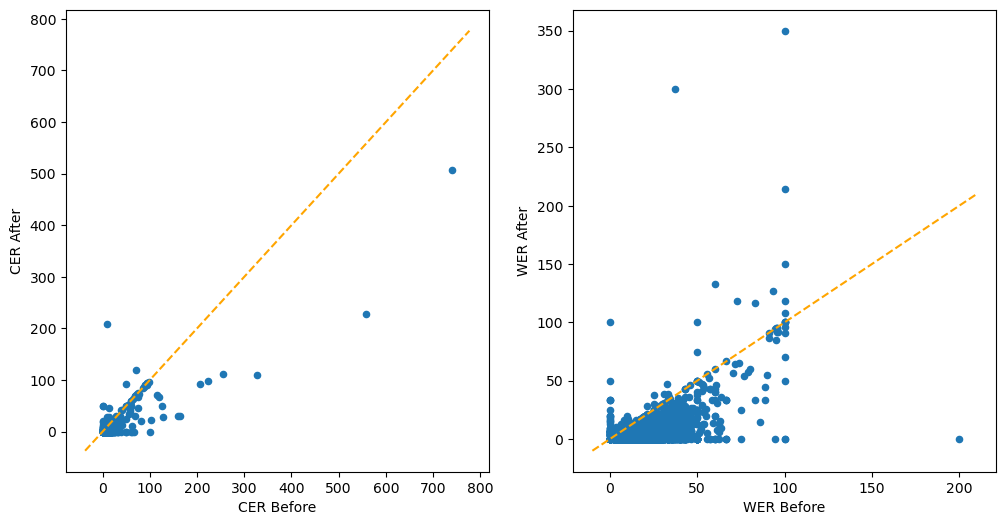

In [100]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [114]:
def get_iqr(df_byt5_words,col):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

In [115]:
def get_iqr_by_value(colvalue):
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

In [116]:
def get_stats(df_byt5_words,col, round_val = 2, print_nans=False):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    # how many nan's
    if print_nans: print('# NaNs =', len(df_byt5_words[col])-len(colvalue))
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)

In [117]:
def get_improvement_stats(df_byt5_words,col_before, col_after, round_val = 2):
    colvalueb = df_byt5_words[col_before]
    colvalueb = colvalueb[~np.isnan(colvalueb)]
    colvaluea = df_byt5_words[col_after]
    colvaluea = colvaluea[~np.isnan(colvaluea)]
    mask = colvalueb != 0
    colvalue = 100*(1-colvaluea[mask]/colvalueb[mask])
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)    

In [118]:
def save_dat(fname,data,formatting = None):
    if formatting is not None:
        all_arts = "{:,}".format(successful_align_pages)
    else:
        all_arts = data
    with open(fname, 'w') as f:
        print(all_arts, file=f,end='')

In [119]:
print('--------- Before -------------')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words,'CER Before', print_nans=True)
print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words,'WER Before')
print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
print('')
print('--------- After -------------')
mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words,'CER After')
print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words,'WER After')
print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
print('')
# improvement
#improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words,'CER Before', 'CER After')
print('------------ Improvement ----------------')
print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words,'WER Before', 'WER After')
print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)

# save all of these

--------- Before -------------
# NaNs = 2
CER : mean = 5.5 , std = 17.46 , median = 3.01 , iqr = 5.22
WER : mean = 15.34 , std = 14.53 , median = 13.04 , iqr = 17.46

--------- After -------------
CER : mean = 2.08 , std = 11.16 , median = 0.0 , iqr = 1.31
WER : mean = 4.18 , std = 12.17 , median = 0.0 , iqr = 5.0

------------ Improvement ----------------
CER : mean =  75.6 , std = 54.01 , median = 100.0 , iqr = 36.44
WER : mean =  78.06 , std = 34.36 , median = 100.0 , iqr = 33.33


In [107]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w]
names_start = 'byt5_onlyWords_small'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d)

## Byt5, Historical, Only Words

In [121]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/historical/'

ender = '_small_words' # 100k for training, 5k val

In [122]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_h = d.copy()
    else: # others
        df_byt5_words_h = pd.concat([df_byt5_words_h,d],ignore_index=True)

In [123]:
df_byt5_words_h.head()

,input_text_unclean,target_text_unclean,filename,page,sent num,type,input_text,target_text,predicted_text
0,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...",1905ApJ____22____1R,0,3,plain,"In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he...","In 1859, when only twenty-one years of age, he..."
1,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",1907ApJ____25__218B,9,0,plain,*Both the nebula and the comet are seen on a n...,"""Both the nebula and the comet are seen on a n...",Both the nebula and the comet are seen on a n...
2,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...",1910ApJ____32___26R,6,11,plain,"A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d...","A plate can be exposed night after night, if d..."
3,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...",1913ApJ____38__407M,86,0,plain,"ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t...","ture only, we must assume that, as we ascend t..."
4,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...",1916ApJ____44___65W,4,3,plain,"An image of it was pro-jected upon the plate, ...","An image of it was projected upon the plate, g...","An image of it was pro-jected upon the plate, ..."


In [124]:
df_byt5_words_h = calc_cer_wer(df_byt5_words_h.copy())

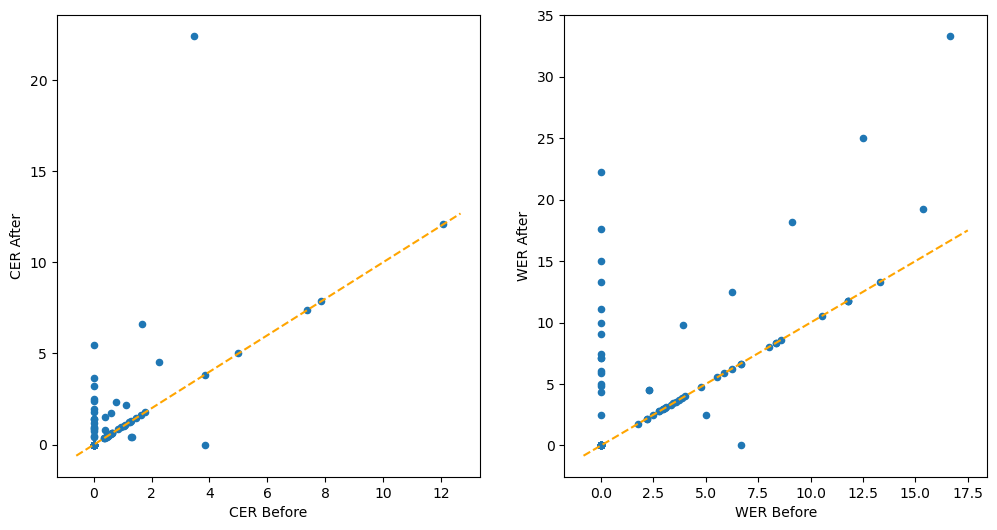

In [125]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_h.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_h.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [126]:
print('--------- Before -------------')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_h,'CER Before', print_nans=True)
print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_h,'WER Before')
print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
print('')
print('--------- After -------------')
mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_h,'CER After')
print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_h,'WER After')
print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
print('')
# improvement
#improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_h,'CER Before', 'CER After')
print('------------ Improvement ----------------')
print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_h,'WER Before', 'WER After')
print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)

# save all of these

--------- Before -------------
# NaNs = 0
CER : mean = 0.68 , std = 1.71 , median = 0.0 , iqr = 0.59
WER : mean = 2.37 , std = 3.9 , median = 0.0 , iqr = 3.48

--------- After -------------
CER : mean = 1.19 , std = 2.79 , median = 0.37 , iqr = 1.18
WER : mean = 4.21 , std = 6.1 , median = 2.17 , iqr = 6.35

------------ Improvement ----------------
CER : mean =  -39.43 , std = 117.01 , median = 0.0 , iqr = 0.0
WER : mean =  -15.24 , std = 46.39 , median = 0.0 , iqr = 0.0


So, just with words, doesn't really fix anything, which is interesting.

## byt5, full, arxiv

In [127]:
# only words, byt5
output_dir_inf = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/inferences/latex_full/'

ender = '_full_large' # 100k for training, 5k val

In [128]:
inf_files = glob(output_dir_inf + '*'+ender+'.csv')
inf_files.sort()
for i,f in enumerate(inf_files):
    d = pd.read_csv(f)
    if i == 0: # first
        df_byt5_words_full = d.copy()
    else: # others
        df_byt5_words_full = pd.concat([df_byt5_words_full,d],ignore_index=True)

In [129]:
df_byt5_words_full.head()

,aligned sentences source,aligned sentences target,input_text,target_text,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,predicted_text
0,A histogram of the ^^^^^^^Va^^^ /slope for dw...,A histogram of the $_{\rm max}$ /slope for dw...,A histogram of the Va /slope for dwarf irregu...,A histogram of the $_{\rm max}$ /slope for dw...,W WWWWWWWWW WW WWW ^^^^^^^II^^^ WWWWWW WWW WW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,W WWWWWWWWW WW WWW II WWWWWW WWW WWWWW WWWWWW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,A histogram of the $V_{\rm d}$ /slope for dwa...
1,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,We conclude that there does not appear to be ...
2,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,The central mass is surrounded by a quasi-sta...
3,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,This means that the BAT is well suited for fi...
4,In general. it is well established that the m...,"In general, it is well established that the m...",In general. it is well established that the m...,"In general, it is well established that the m...",WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,"In general, it is well established that the m..."


In [130]:
df_byt5_words_full = calc_cer_wer(df_byt5_words_full.copy())

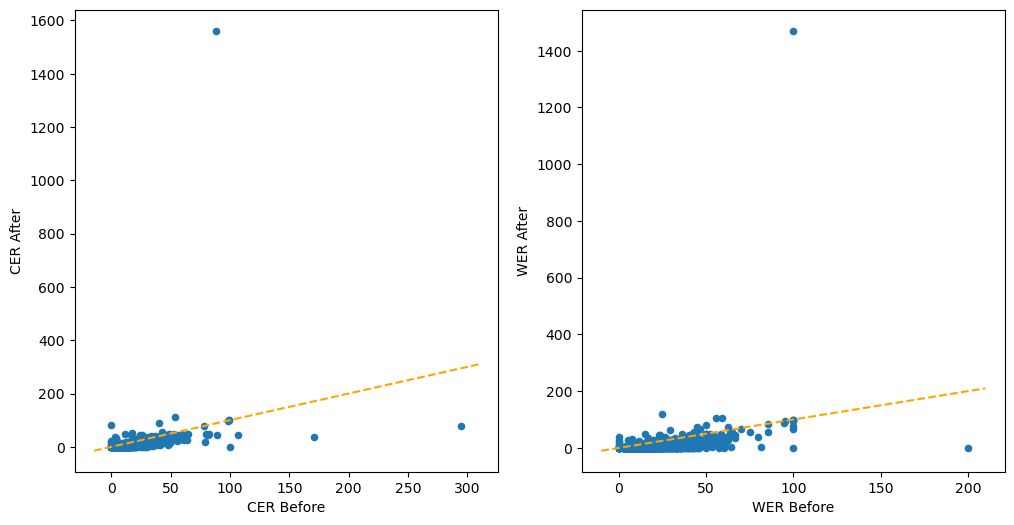

In [131]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_full.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_full.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [132]:
print('--------- Before -------------')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_full,'CER Before', print_nans=True)
print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_full,'WER Before')
print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
print('')
print('--------- After -------------')
mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_full,'CER After')
print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_full,'WER After')
print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
print('')
# improvement
#improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_full,'CER Before', 'CER After')
print('------------ Improvement ----------------')
print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_full,'WER Before', 'WER After')
print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)

--------- Before -------------
# NaNs = 0
CER : mean = 12.32 , std = 16.12 , median = 7.58 , iqr = 14.52
WER : mean = 20.01 , std = 16.62 , median = 17.65 , iqr = 19.44

--------- After -------------
CER : mean = 7.24 , std = 42.01 , median = 1.27 , iqr = 8.3
WER : mean = 9.04 , std = 40.37 , median = 3.57 , iqr = 10.53

------------ Improvement ----------------
CER : mean =  60.44 , std = 78.43 , median = 73.33 , iqr = 57.89
WER : mean =  62.44 , std = 59.9 , median = 75.0 , iqr = 57.14


In [133]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w]
names_start = 'byt5_full_large'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d)

## byt5, full, with fixes

In [154]:
df_byt5_words_full_fix = fix_ocr(df_byt5_words_full.copy())

In [157]:
df_byt5_words_full_fix.head()

,aligned sentences source,aligned sentences target,input_text,target_text,aligned sentences source types,aligned sentences target types,sentences source types,sentences target types,predicted_text,CER Before,...,CER Orig,WER Orig,CER Corrected,WER Corrected,CER Fix Corrected,WER Fix Corrected,CER Fix,WER Fix,target_text_fixed,predicted_text_fixed
0,A histogram of the ^^^^^^^Va^^^ /slope for dw...,A histogram of the $_{\rm max}$ /slope for dw...,A histogram of the Va /slope for dwarf irregu...,A histogram of the $_{\rm max}$ /slope for dw...,W WWWWWWWWW WW WWW ^^^^^^^II^^^ WWWWWW WWW WW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,W WWWWWWWWW WW WWW II WWWWWW WWW WWWWW WWWWWW...,W WWWWWWWWW WW WWW IIIIIIIIIIII WWWWWW WWW WW...,A histogram of the $V_{\rm d}$ /slope for dwa...,18.5393,...,18.5393,25.0000,7.8652,9.3750,0.0000,0.0000,7.1895,22.5806,A histogram of the $ /slope for dwarf irregul...,A histogram of the $ /slope for dwarf irregul...
1,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,We conclude that there does not appear to he ...,We conclude that there does not appear to be ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,WW WWWWWWWW WWWW WWWWW WWWW WWW WWWWWW WW WW ...,We conclude that there does not appear to be ...,4.5802,...,4.5802,16.0000,0.0000,0.0000,0.0000,0.0000,4.5802,16.0000,We conclude that there does not appear to be ...,We conclude that there does not appear to be ...
2,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,WWW WWWWWWW WWWW WW WWWWWWWWWW WW W WWWWWWWWW...,The central mass is surrounded by a quasi-sta...,5.0000,...,5.0000,7.6923,0.0000,0.0000,0.0000,0.0000,5.0000,7.6923,The central mass is surrounded by a quasi-sta...,The central mass is surrounded by a quasi-sta...
3,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,WWWW WWWWW WWWW WWW WWW WW WWWW WWWWWW WWW WW...,This means that the BAT is well suited for fi...,4.3478,...,4.3478,6.8966,0.0000,0.0000,0.0000,0.0000,4.3478,6.8966,This means that the BAT is well suited for fi...,This means that the BAT is well suited for fi...
4,In general. it is well established that the m...,"In general, it is well established that the m...",In general. it is well established that the m...,"In general, it is well established that the m...",WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,WW WWWWWWWW WW WW WWWW WWWWWWWWWWW WWWW WWW W...,"In general, it is well established that the m...",4.8346,...,4.8346,15.0000,0.7634,1.6667,0.7772,1.6949,3.3679,13.5593,"In general, it is well established that the m...","In general, it is well established that the m..."


In [173]:
df_byt5_words_full_fix = calc_cer_wer(df_byt5_words_full_fix.copy(), 
                                      target_text_col='target_text_fixed', 
                                     predicted_text_col = 'predicted_text_fixed')

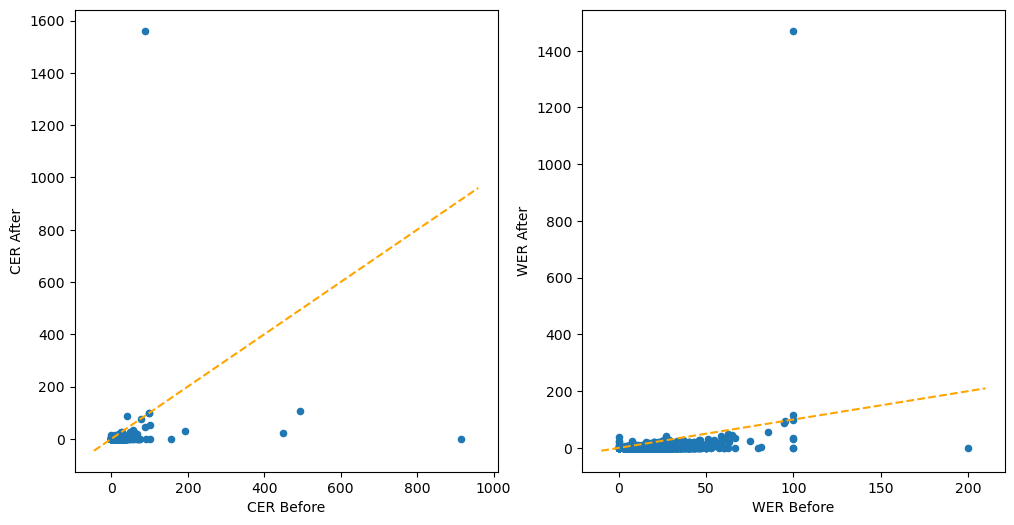

In [174]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
df_byt5_words_full_fix.plot(x = 'CER Before', y = 'CER After', kind='scatter',ax=ax[0])
xlim = ax[0].get_xlim()
ylim = ax[0].get_ylim()
ax[0].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

df_byt5_words_full_fix.plot(x = 'WER Before', y = 'WER After', kind='scatter',ax=ax[1])
xlim = ax[1].get_xlim()
ylim = ax[1].get_ylim()
ax[1].plot([xlim[0],xlim[1]], [xlim[0],xlim[1]], '--', color='orange')

plt.show()

In [175]:
print('--------- Before -------------')
mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(df_byt5_words_full_fix,'CER Before', print_nans=True)
print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(df_byt5_words_full_fix,'WER Before')
print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
print('')
print('--------- After -------------')
mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(df_byt5_words_full_fix,'CER After')
print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(df_byt5_words_full_fix,'WER After')
print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
print('')
# improvement
#improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
mea_c,med_c,std_c,iqr_c = get_improvement_stats(df_byt5_words_full_fix,'CER Before', 'CER After')
print('------------ Improvement ----------------')
print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
mea_w,med_w,std_w,iqr_w = get_improvement_stats(df_byt5_words_full_fix,'WER Before', 'WER After')
print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)

--------- Before -------------
# NaNs = 0
CER : mean = 10.86 , std = 32.13 , median = 5.62 , iqr = 9.78
WER : mean = 18.85 , std = 15.78 , median = 16.67 , iqr = 17.61

--------- After -------------
CER : mean = 2.69 , std = 41.28 , median = 0.0 , iqr = 1.03
WER : mean = 4.12 , std = 39.13 , median = 0.0 , iqr = 4.0

------------ Improvement ----------------
CER : mean =  84.75 , std = 56.92 , median = 100.0 , iqr = 16.67
WER : mean =  84.44 , std = 48.49 , median = 100.0 , iqr = 22.22


In [176]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w]
names_start = 'byt5_full_large_fix'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d)

## byt5, full, classification

In [190]:
def make_classification_metrics(dfout_err_h, target_text_col='target_text_fixed',
                               predicted_text_col='predicted_text_fixed',
                               marks = {'`':'citations', '*':'refs', '$':'inlines'}):
    
    classification_metrics = {'citations':{'FP':0, 'FN':0, 'TP':0, 'total true':0}, 
                              'inlines':{'FP':0, 'FN':0, 'TP':0, 'total true':0},
                              'refs':{'FP':0, 'FN':0, 'TP':0, 'total true':0}}


    for i in range(len(dfout_err_h)):
        d = dfout_err_h.iloc[i]
        # align predicted and target
        page_text_gt = d[target_text_col]
        page_text_ocr = d[predicted_text_col]
        eops = Levenshtein.editops(page_text_ocr, page_text_gt)
        ocr_text_aligned, pdf_text_aligned = align_texts_fast(page_text_ocr, 
                                                              page_text_gt, 
                                                              eops)
        # loop
        for p,o in zip(pdf_text_aligned,ocr_text_aligned):
            if p in list(marks.keys()): # special mark
                if p == o: # got it!
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[p]]['TP'] += 1
                elif (p != o) and (o in list(marks.keys())): # not right mark, but in marks
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[o]]['FP'] += 1
                else: # p is a mark, but missed it in ocr
                    classification_metrics[marks[p]]['total true'] += 1
                    classification_metrics[marks[p]]['FN'] += 1
            elif o in list(marks.keys()): # have ocr instead!
                classification_metrics[marks[o]]['FP'] += 1
    return classification_metrics

def prec_rec_f1(classification_metrics):
    for t,v in classification_metrics_latex.items():
        if v['total true'] > 0: # have it
            print(t)
            print(v)
            #Precision = TruePositives / (TruePositives + FalsePositives)
            if v['TP'] + v["FP"] > 0:
                prec = v['TP']/(v['TP'] + v["FP"])
            else:
                prec = 0
            #Recall = TruePositives / (TruePositives + FalseNegatives)
            if v['TP']+v['FN'] > 0:
                rec = v['TP']/(v['TP']+v['FN'])
            else:
                rec = 0

            # F-Measure = (2 * Precision * Recall) / (Precision + Recall)
            if prec+rec > 0:
                f1 = (2*prec*rec)/(prec+rec)
            else:
                f1 = 0

            print('prec =', prec, ', rec =', rec, ', f1 = ', f1)
            print('')

In [187]:
#df_byt5_words_full_fix.head()

In [191]:
classification_metrics_latex = make_classification_metrics(df_byt5_words_full_fix)

In [192]:
print('-------- LaTeX ---------')
prec_rec_f1(classification_metrics_latex)

-------- LaTeX ---------
citations
{'FP': 7, 'FN': 15, 'TP': 229, 'total true': 249}
prec = 0.9703389830508474 , rec = 0.9385245901639344 , f1 =  0.9541666666666667

inlines
{'FP': 81, 'FN': 121, 'TP': 949, 'total true': 1071}
prec = 0.9213592233009709 , rec = 0.8869158878504673 , f1 =  0.9038095238095238

refs
{'FP': 18, 'FN': 12, 'TP': 157, 'total true': 169}
prec = 0.8971428571428571 , rec = 0.9289940828402367 , f1 =  0.9127906976744186

